<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/cnn/practical_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Image Recognition

* Data Loading taken from: https://keras.io/examples/vision/image_classification_from_scratch/

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-d83ce678-672f-f772-a847-ff0cf97190db)


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# in case we do not want GPU
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

In [8]:
# https://github.com/keisen/tf-keras-vis
# https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

if 'google.colab' in sys.modules:
  !pip install -q tf-keras-vis

In [9]:
from lrcurve import KerasLearningCurve

# Step I: Get and Explore data

In [10]:
if 'google.colab' in sys.modules:
    !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [11]:
if 'google.colab' in sys.modules:
    !unzip -oq kagglecatsanddogs_3367a.zip

In [12]:
!ls -l PetImages

total 584
drwxr-xr-x 2 olli olli 294912 Nov 26 12:45 Cat
drwxr-xr-x 2 olli olli 294912 Nov 26 12:45 Dog


In [13]:
!ls -l PetImages/Cat | head -5

total 355212
-rw-r--r-- 1 olli olli   12213 Feb 10  2017 0.jpg
-rw-r--r-- 1 olli olli   16868 Feb 10  2017 1.jpg
-rw-r--r-- 1 olli olli   35381 Feb 10  2017 10.jpg
-rw-r--r-- 1 olli olli   30725 Feb 10  2017 100.jpg
ls: write error: Broken pipe


In [14]:
!ls -l PetImages/Dog | head -5

total 421676
-rw-r--r-- 1 olli olli    34448 Feb 10  2017 0.jpg
-rw-r--r-- 1 olli olli    26799 Feb 10  2017 1.jpg
-rw-r--r-- 1 olli olli    24746 Feb 10  2017 100.jpg
-rw-r--r-- 1 olli olli    24358 Feb 10  2017 1000.jpg
ls: write error: Broken pipe


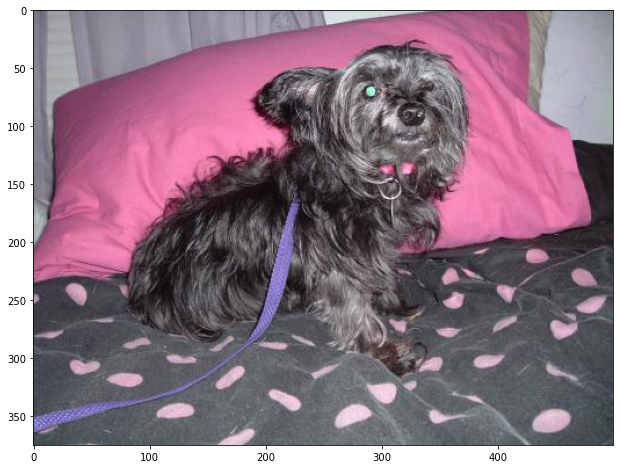

In [15]:
from skimage import io

sample = 'PetImages/Dog/0.jpg'
image = io.imread(sample)
plt.imshow(image);

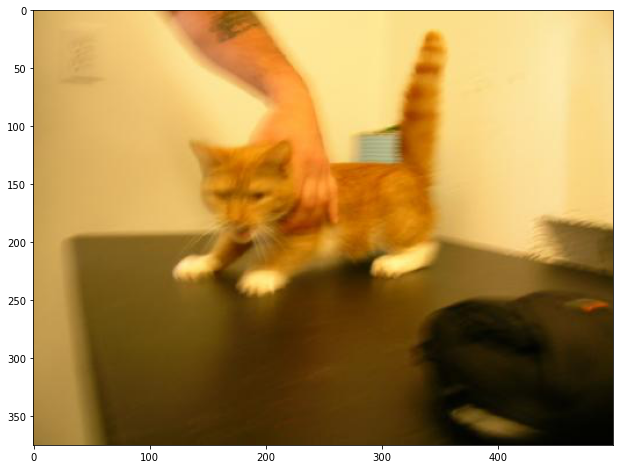

In [16]:
sample = 'PetImages/Cat/0.jpg'
image = io.imread(sample)
plt.imshow(image);

In [17]:
image.shape

(375, 500, 3)

In [18]:
image.shape[0] / image.shape[1]

0.75

In [19]:
import os

num_valid = 0
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_valid += 1


print(f'Deleted {num_skipped} images, keeping {num_valid}')

Deleted 0 images, keeping 23412


# Step II: Prepare data for training

* we need training data and at least one test/validation set
* realistic datasets are too big to keep in memory
* need to stream them
* keras has some nice helper libraries for that
  * helper just saves some work, but does nothing too fancy
  * you can also build this from scratch: https://www.tensorflow.org/guide/data


In [20]:
# tf.keras.preprocessing.image_dataset_from_directory?

In [21]:
x_size = 75
y_size = 100
image_size = (y_size, x_size)
# image_size = (180, 180)
batch_size = 32
seed=1337

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [22]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 100, 75, 3]), TensorShape([32]))

In [23]:
image = image_batch[0]
image.shape

TensorShape([100, 75, 3])

In [24]:
import numpy as np

image_np = image.numpy()
image_np.dtype

dtype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


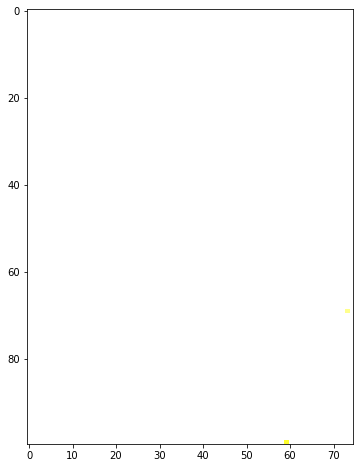

In [25]:
plt.imshow(image_np);

In [26]:
np.min(image_np), np.max(image_np)

(0.1723175, 255.0)

In [27]:
# plt.hist(np.unique(image));

In [28]:
image_np = image_np / 255.0
np.min(image_np), np.max(image_np)

(0.0006757549, 1.0)

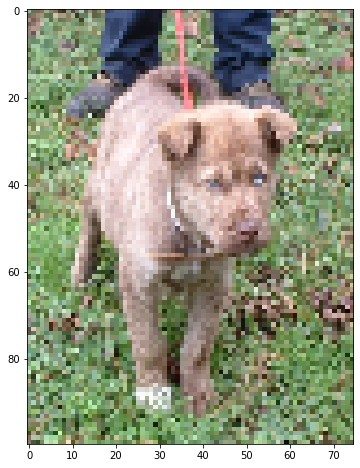

In [29]:
plt.imshow(image_np);

In [30]:
label_names = ['Cat', 'Dog']

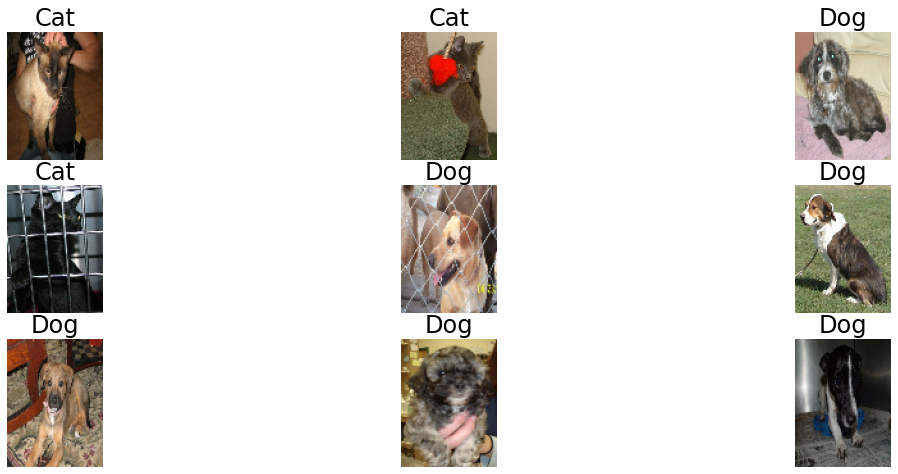

In [31]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[int(labels[i])])
        plt.axis("off")

# Step III: Training

In [32]:
# network takes float anyway and likes values close to 0
# we could bring this into GPU processing by making it a TF function
normalized_train_ds = train_ds.map(lambda image, label: (image / 255.0, label))
normalized_val_ds = val_ds.map(lambda image, label: (image / 255.0, label))

In [33]:
input_shape=(y_size, x_size, 3)
num_classes = 2

In [34]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(Input(shape=input_shape))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 74, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 37, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 37, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 49, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 36, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 18, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 18, 64)        2

In [35]:
%%time

epochs = 15

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

CPU times: user 9min 41s, sys: 1min 7s, total: 10min 49s
Wall time: 1min 27s


In [ ]:
model.save('vgg-light.h5')

# Step IV: Evaluation

In [326]:
# uncomment to evaluate a specifc model, history will not work, though

# model = tf.keras.models.load_model('vgg-light.h5')
# model = tf.keras.models.load_model('resnet50.h5')
# model = tf.keras.models.load_model('mobilenet.h5')
# model = tf.keras.models.load_model('mobilenetv2.h5')
# model = tf.keras.models.load_model('mobilenetv2-transfer.h5')
# model = tf.keras.models.load_model('mobilenetv2-transfer-fine-tuning.h5')

In [321]:
train_loss, train_accuracy = model.evaluate(normalized_train_ds)
train_accuracy
# VGG light: 0.9919

586/586 [==============================] - 7s 12ms/step - loss: 0.4146 - accuracy: 0.8041


0.804090142250061

In [313]:
test_loss, test_accuracy = model.evaluate(normalized_val_ds)
test_accuracy
# VGG light: 0.8020

147/147 [==============================] - 2s 12ms/step - loss: 0.2609 - accuracy: 0.8864


0.8863733410835266

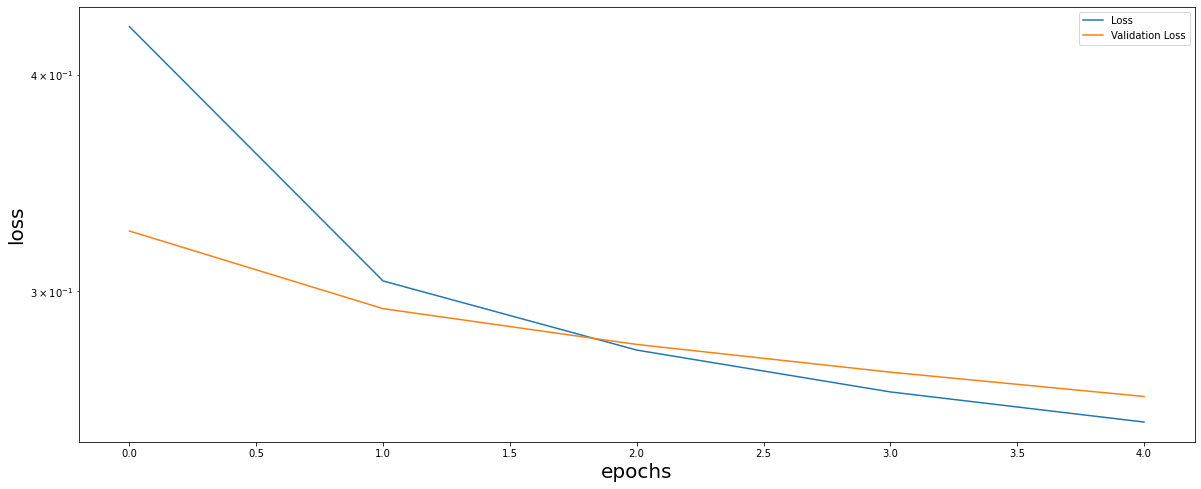

In [314]:
plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss']);

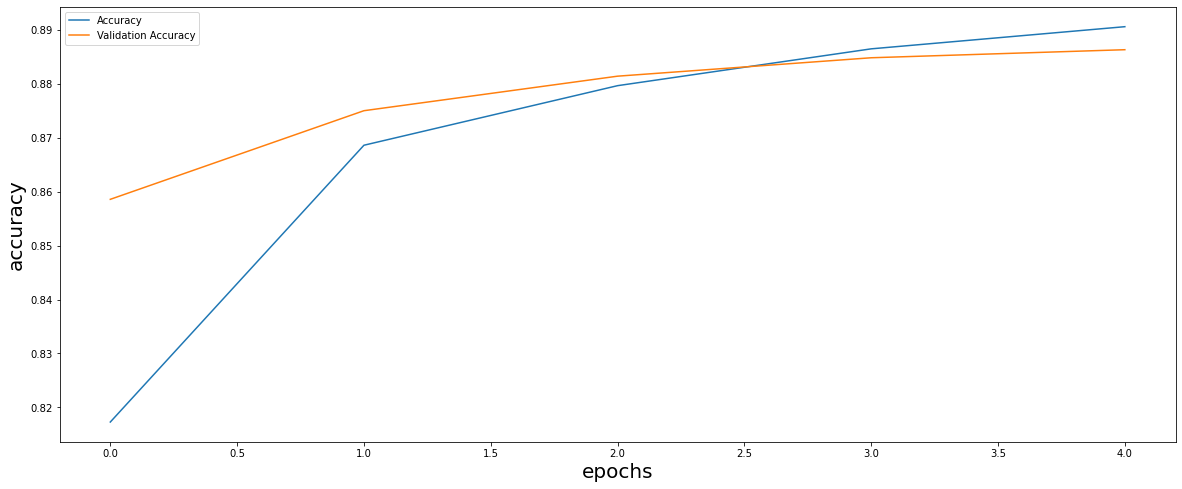

In [315]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy']);

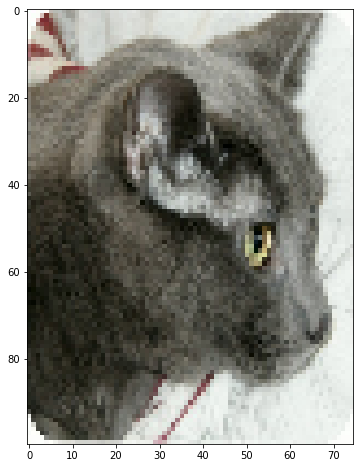

In [267]:
img = tf.keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
) 
plt.imshow(img);

In [268]:
CAT = 0
DOG = 1

# be careful, networks fail silently, don't forget to normalize to 0..1
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(f'This image is {100 * score[CAT]} percent cat and {100 * score[DOG]} percent dog.')

This image is 99.98151659965515 percent cat and 0.018489753711037338 percent dog.


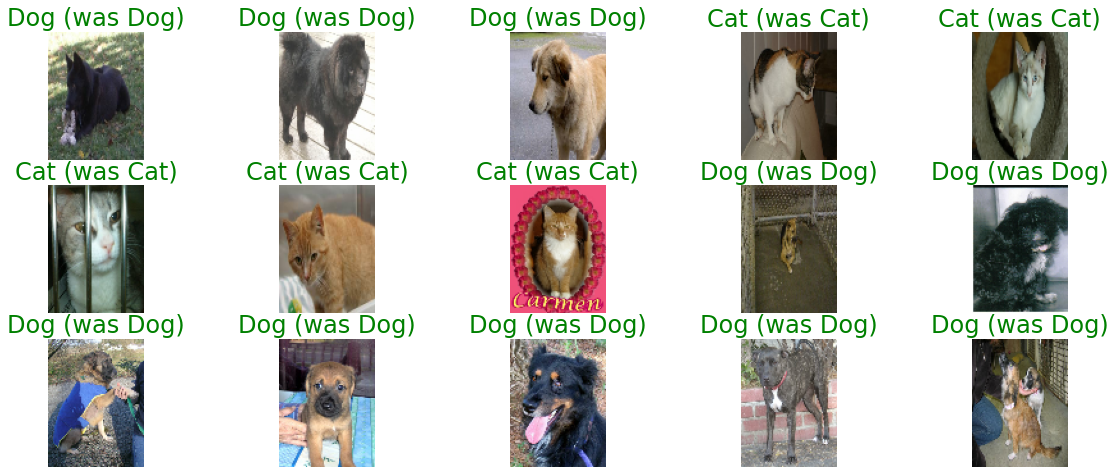

In [269]:
for images, labels in normalized_val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        image = images[i]
        y_true = labels[i]
        y_pred = model.predict(tf.expand_dims(image, 0)).argmax(axis=1)[0]
        plt.imshow(images[i])
        plt.title("{} (was {})".format(label_names[y_pred], 
                                  label_names[y_true]),
                                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")

# Step V: Looking at Categories

In [270]:
def plot_gallery(model, X, y, size=15):
    figure = plt.figure(figsize=(40, 20))

    y_pred_raw = model.predict(X)
    certainty = y_pred_raw.max(axis=1)
    y_pred = y_pred_raw.argmax(axis=1)
    population = X.shape[0]

    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image)
        y_true = y[i]
        y_pred = model.predict(tf.expand_dims(image, 0)).argmax(axis=1)[0]
        plt.title("{} (was {}): {} ({:3d}%)".format(label_names[y_pred],
                                                  label_names[y_true],
                                                  i,
                                                  int(certainty[i] * 100)),
                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")
    return certainty.max(), certainty.min(), certainty.mean()

In [271]:
sample_size = 1024

In [272]:
# need this to be deterministic as we need y_pred and y_true to be aligned
deterministic_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=sample_size,
    shuffle=True
).map(lambda image, label: (image / 255.0, label))

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [273]:
val_image_batch, val_label_batch = next(iter(deterministic_val_ds))
val_image_batch.shape, val_label_batch.shape

(TensorShape([1024, 100, 75, 3]), TensorShape([1024]))

In [274]:
# would also work on dataset
y_pred = model.predict(val_image_batch).argmax(axis=1)

In [275]:
y_pred.shape

(1024,)

In [276]:
y_pred[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [277]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([503, 521]))

In [278]:
# also possible on dataset
# y_true = np.concatenate(list(deterministic_val_ds.map(lambda image, label: label).as_numpy_iterator()))
y_true = val_label_batch.numpy()

In [279]:
y_true.shape

(1024,)

In [280]:
np.unique(y_true, return_counts=True)

(array([0, 1], dtype=int32), array([523, 501]))

In [281]:
y_true[:10]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

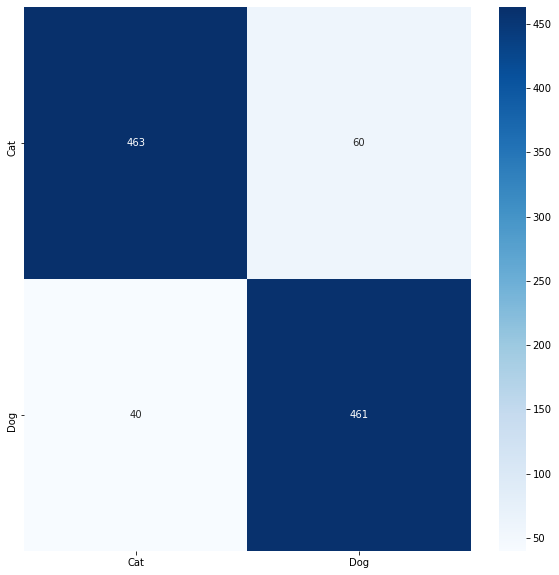

In [282]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
figure = plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d');

(1.0, 0.5037584, 0.9310497)

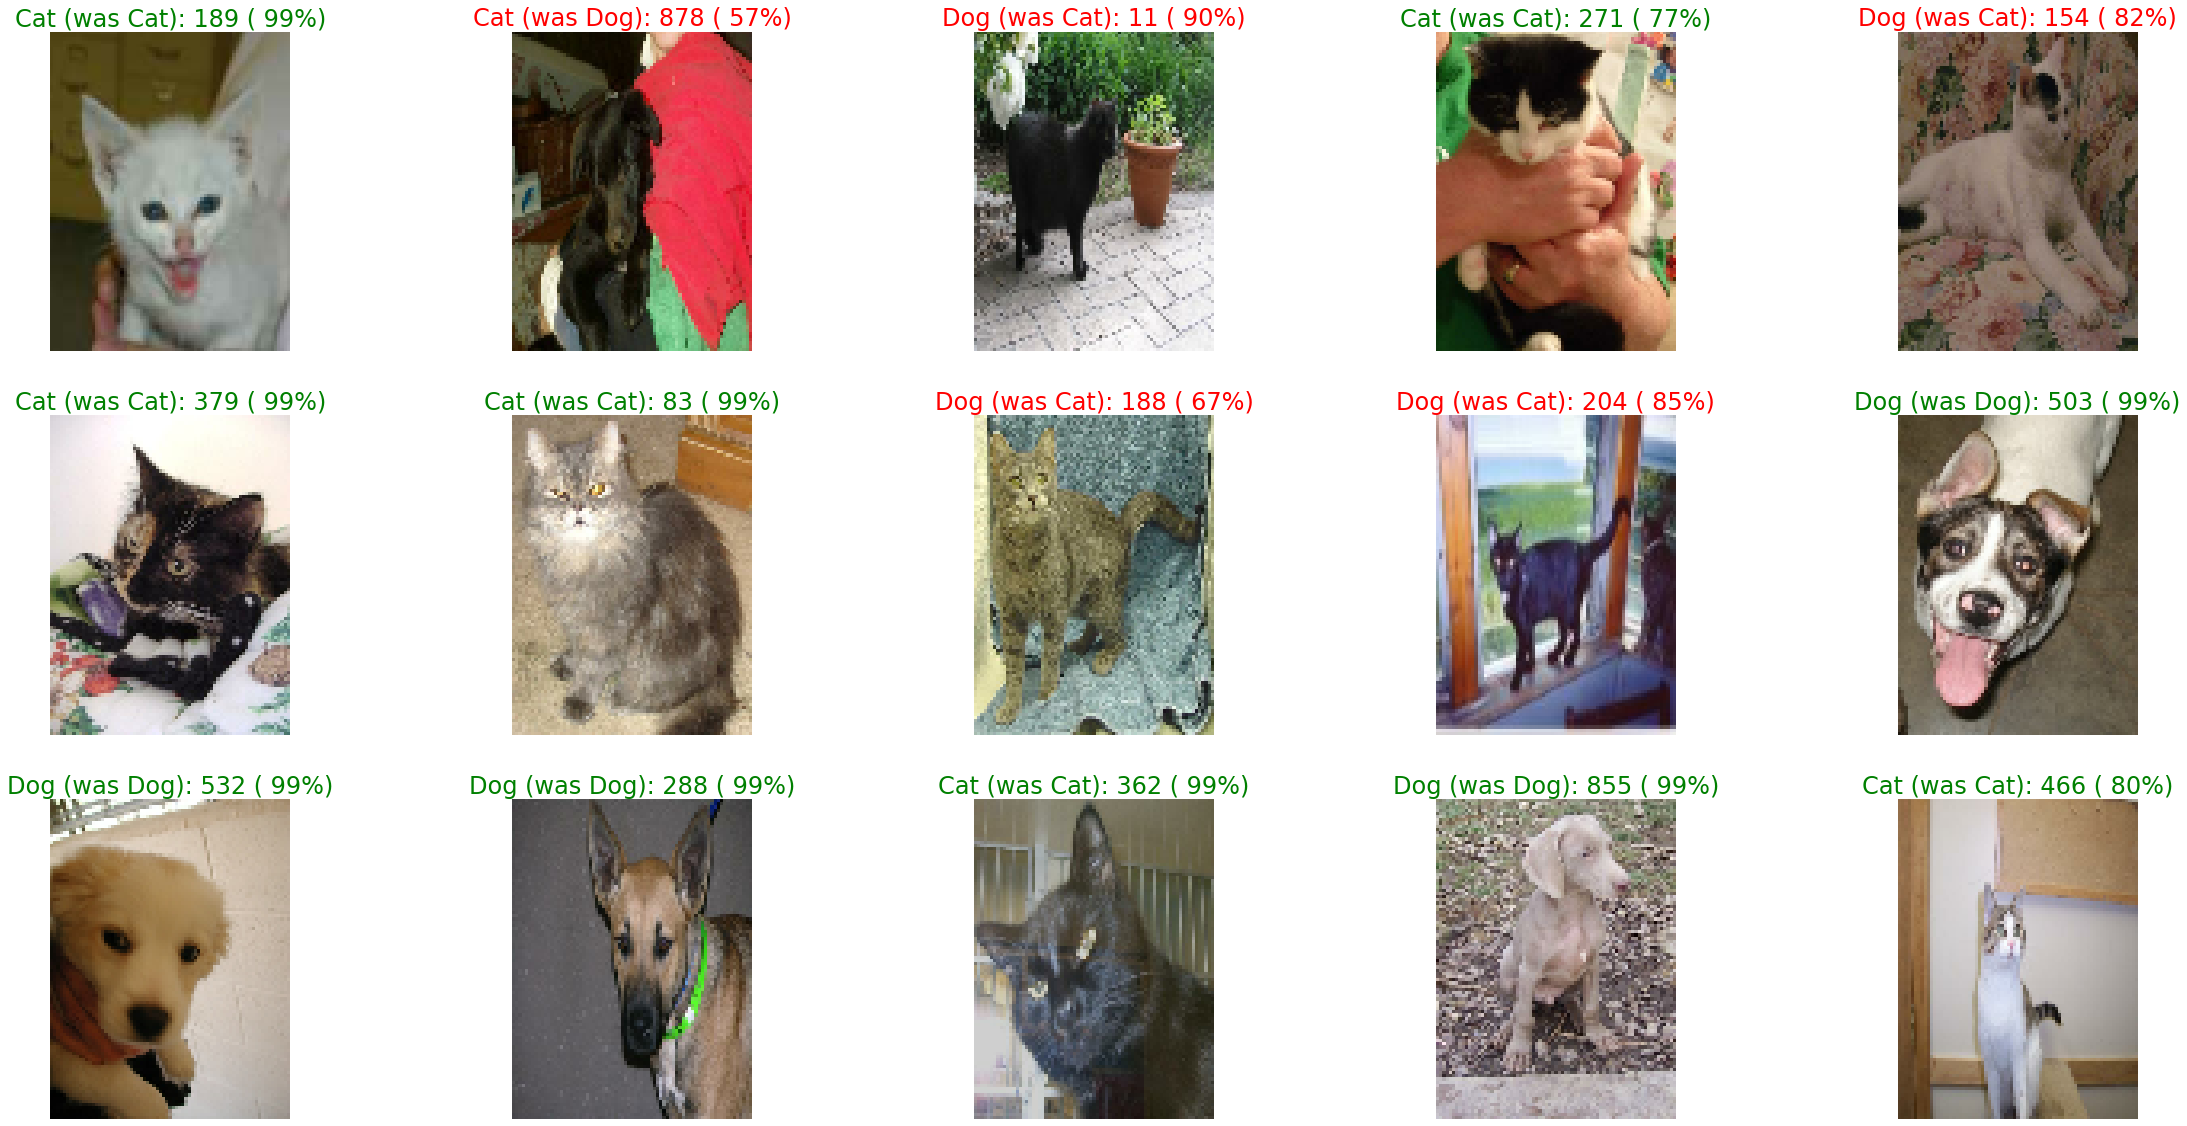

In [283]:
plot_gallery(model, val_image_batch, val_label_batch)

## Category: Low Certainty

In [284]:
y_pred_raw = model.predict(val_image_batch)

In [285]:
# certainty over all
certainty = y_pred_raw.max(axis=1)
certainty.max(), certainty.min(), certainty.mean()

(1.0, 0.5037584, 0.9310497)

In [286]:
threshold = 0.6

In [287]:
certainty_cat = np.where(certainty < threshold)[0]
certainty_cat

array([   0,   30,   34,   40,   68,   94,  113,  140,  181,  203,  221,
        222,  291,  378,  426,  475,  478,  493,  507,  508,  572,  589,
        626,  637,  639,  683,  724,  763,  774,  863,  869,  878,  883,
        905,  908,  911,  919,  932,  935,  977,  999, 1012, 1018])

(0.5994123, 0.50334126, 0.55123353)

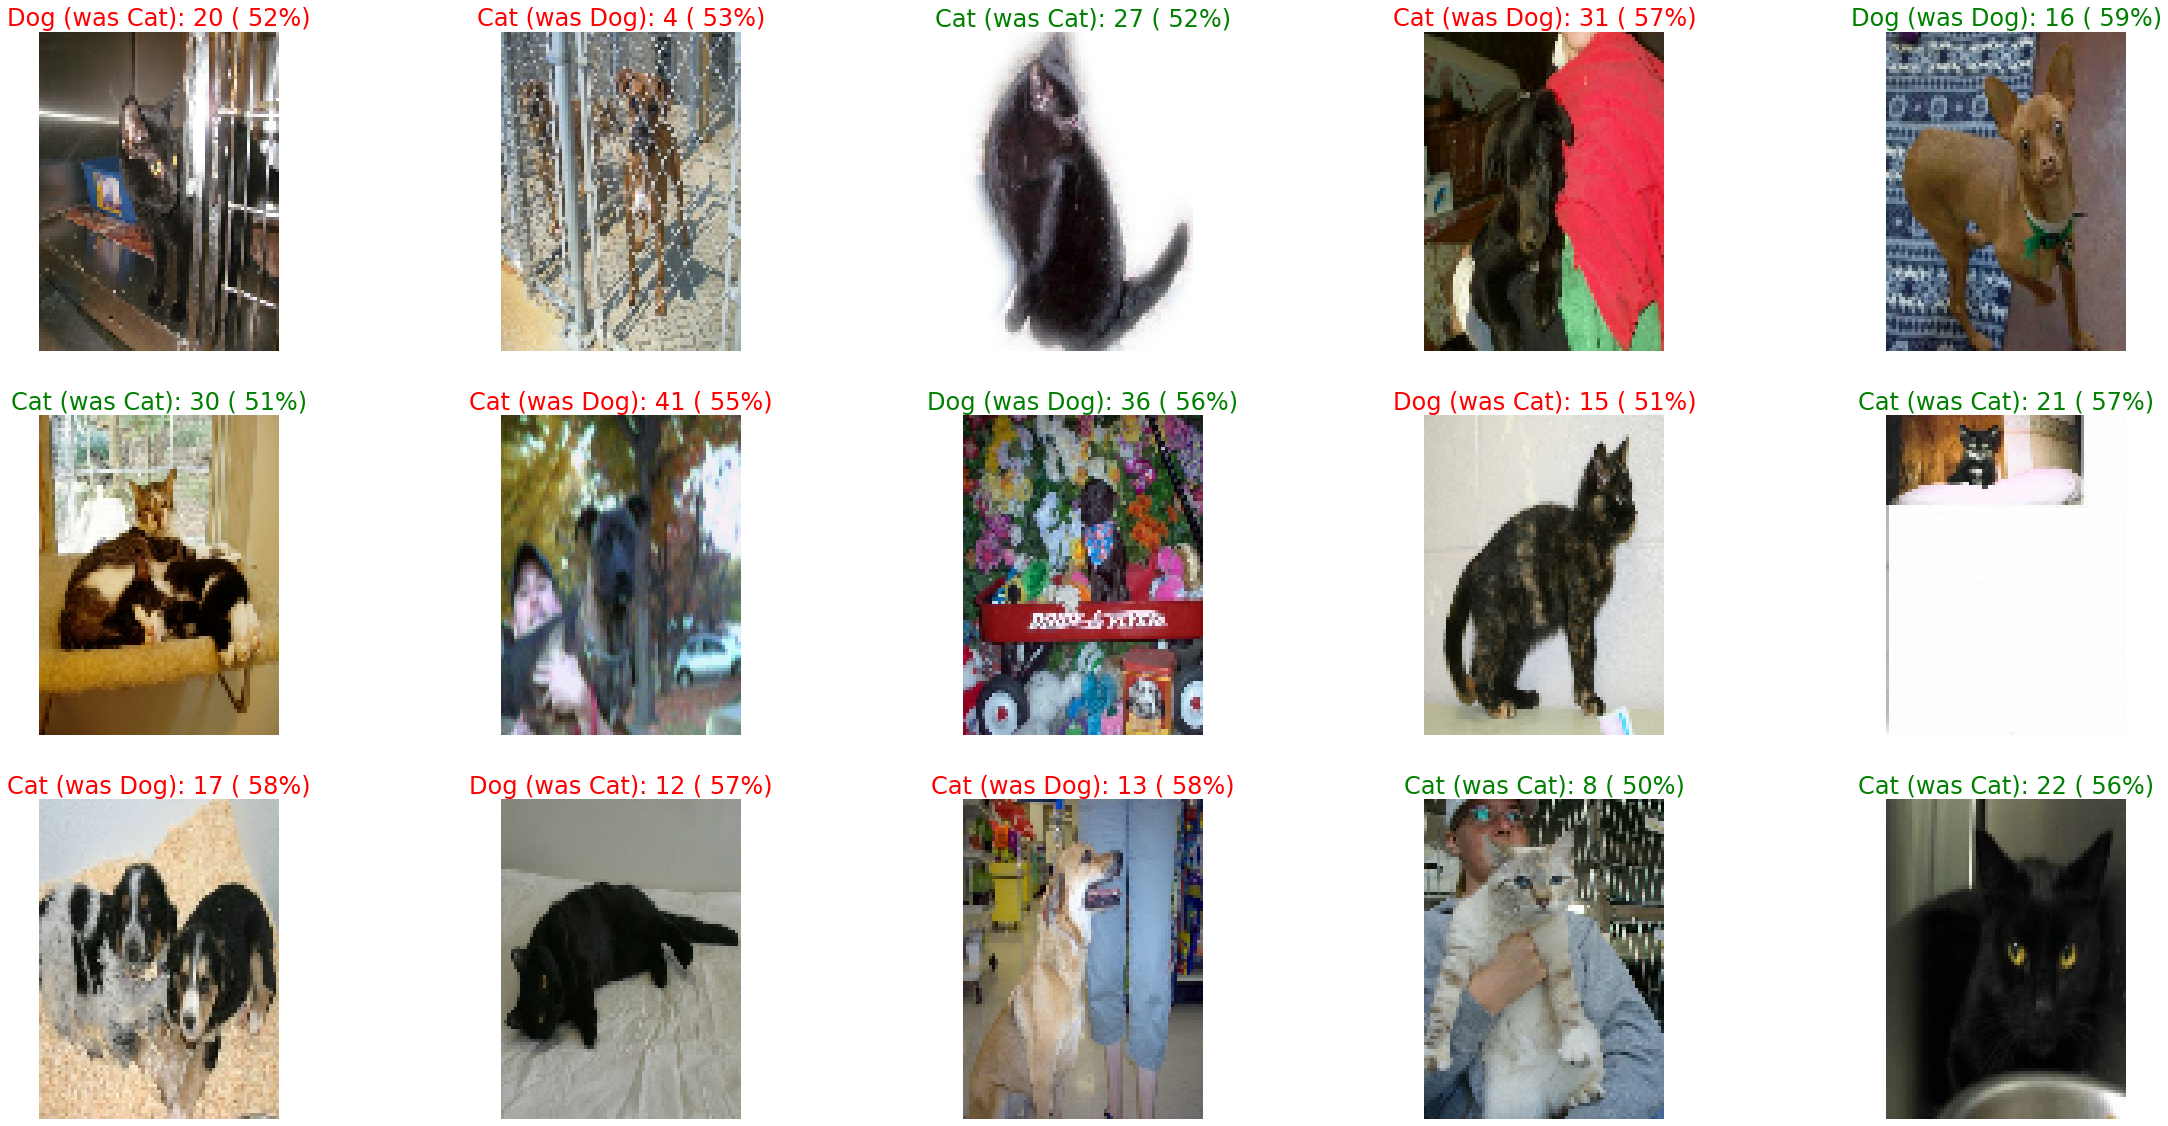

In [288]:
plot_gallery(model, val_image_batch.numpy()[certainty_cat], val_label_batch.numpy()[certainty_cat])

## Category: High Certainty

In [289]:
y_pred_raw = model.predict(val_image_batch)

In [290]:
threshold = 0.99999

In [291]:
certainty_cat = np.where(certainty > threshold)[0]
certainty_cat.shape

(76,)

(1.0, 0.99999034, 0.9999971)

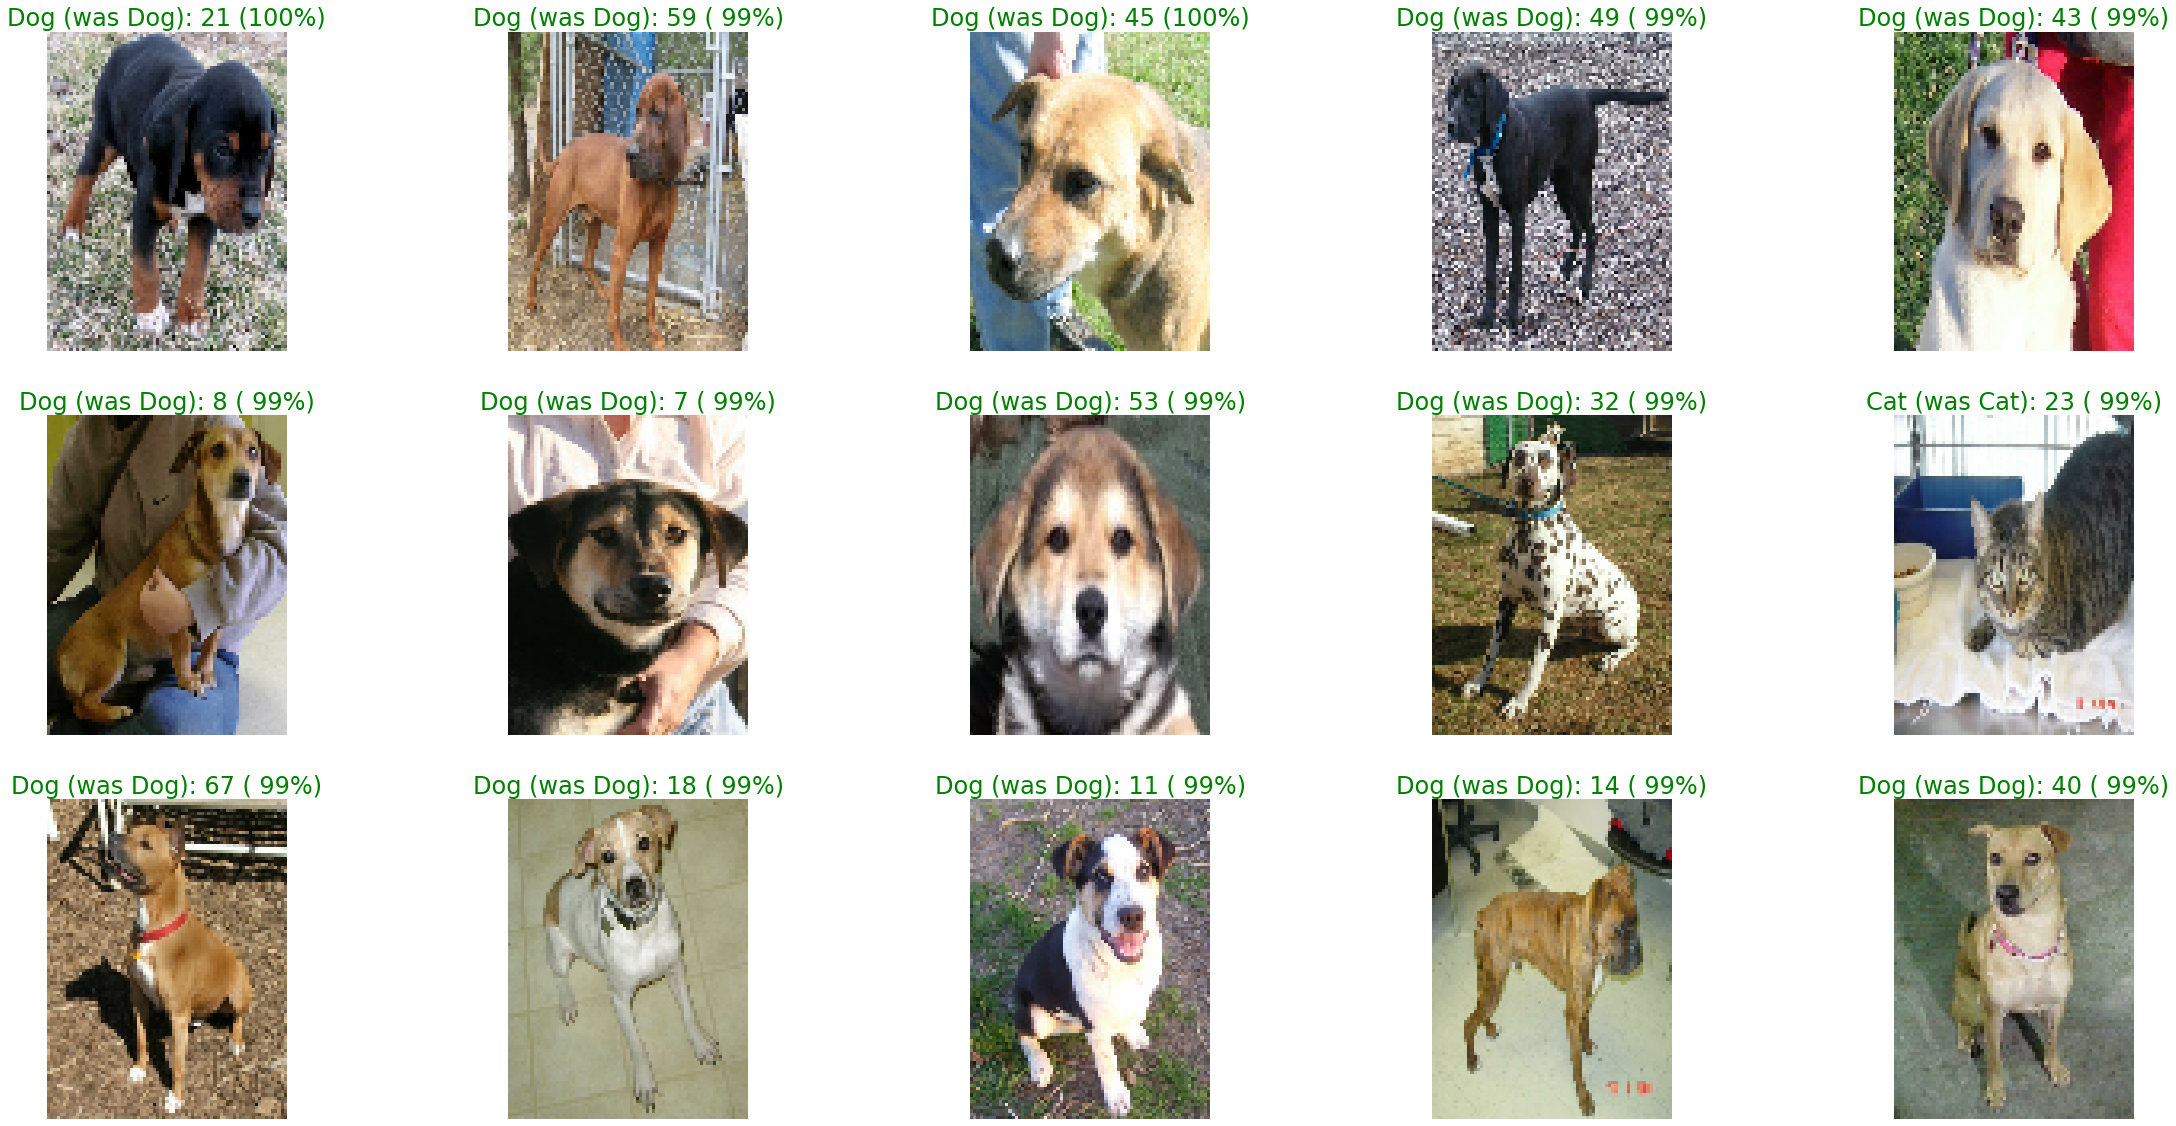

In [292]:
plot_gallery(model, val_image_batch.numpy()[certainty_cat], val_label_batch.numpy()[certainty_cat])

## Category: Wrong

In [293]:
y_true = val_label_batch.numpy()

In [294]:
y_pred = model.predict(val_image_batch).argmax(axis=1)

In [295]:
wrongs = np.where(y_pred != y_true)[0]
wrongs

array([   0,    1,   11,   14,   34,   40,   50,   68,   93,  110,  113,
        127,  129,  154,  164,  168,  180,  188,  190,  198,  199,  203,
        204,  210,  215,  258,  263,  266,  276,  291,  296,  298,  307,
        338,  340,  342,  345,  370,  372,  378,  398,  400,  408,  409,
        418,  426,  444,  445,  475,  493,  497,  507,  519,  533,  552,
        559,  572,  593,  607,  620,  633,  650,  654,  667,  674,  694,
        705,  708,  714,  716,  742,  755,  764,  771,  774,  794,  802,
        808,  815,  828,  830,  867,  870,  875,  878,  893,  898,  923,
        932,  935,  938,  945,  959,  961,  993,  996,  999, 1006, 1012,
       1015])

(0.9999614, 0.5037584, 0.7816111)

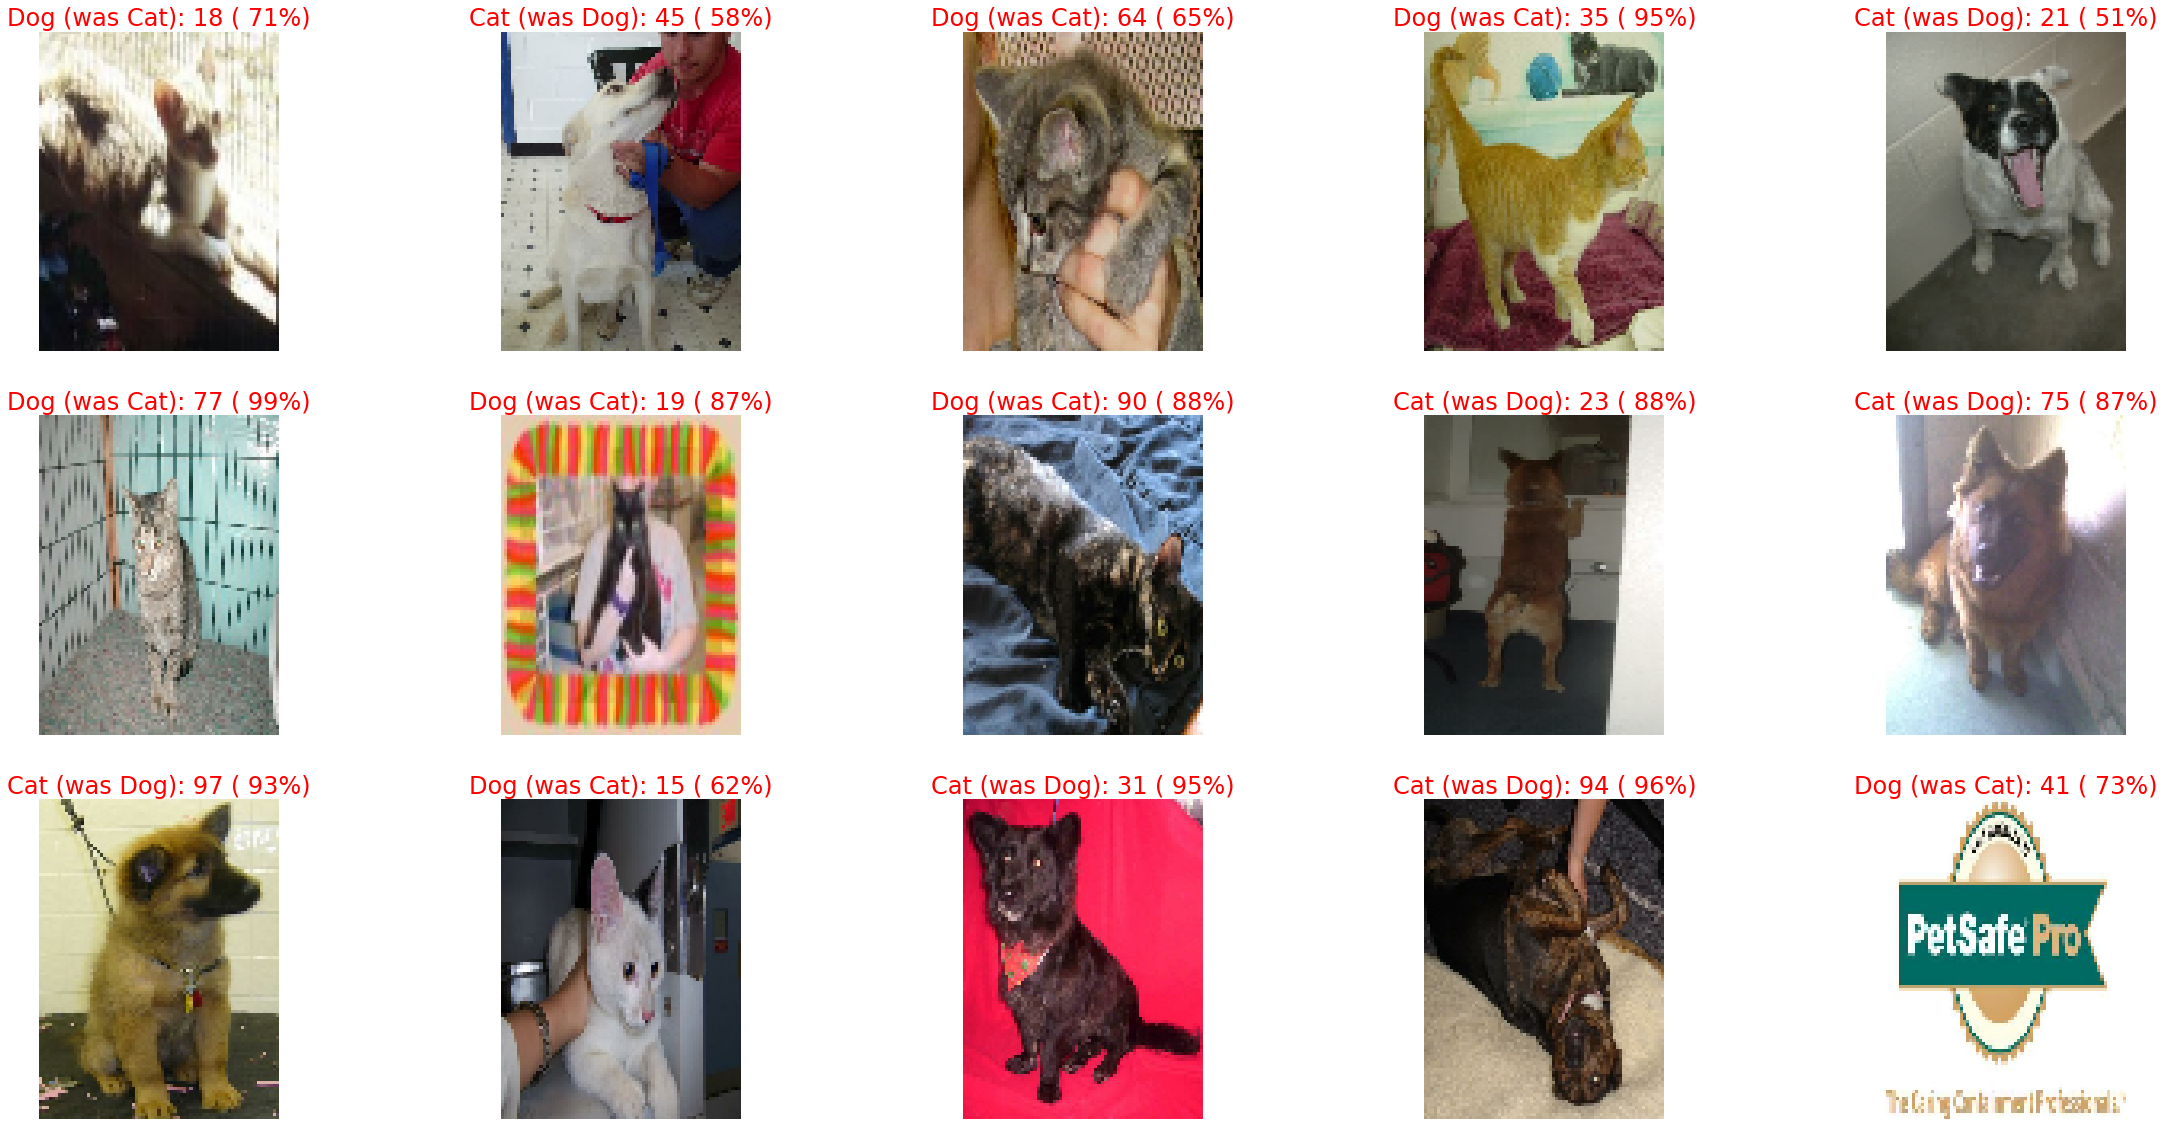

In [296]:
plot_gallery(model, val_image_batch.numpy()[wrongs], val_label_batch.numpy()[wrongs])

## Category: Right

In [297]:
y_true = val_label_batch.numpy()

In [298]:
y_pred = model.predict(val_image_batch).argmax(axis=1)

In [299]:
rights = np.where(y_pred == y_true)[0]
rights.shape

(924,)

(1.0, 0.5041593, 0.9472217)

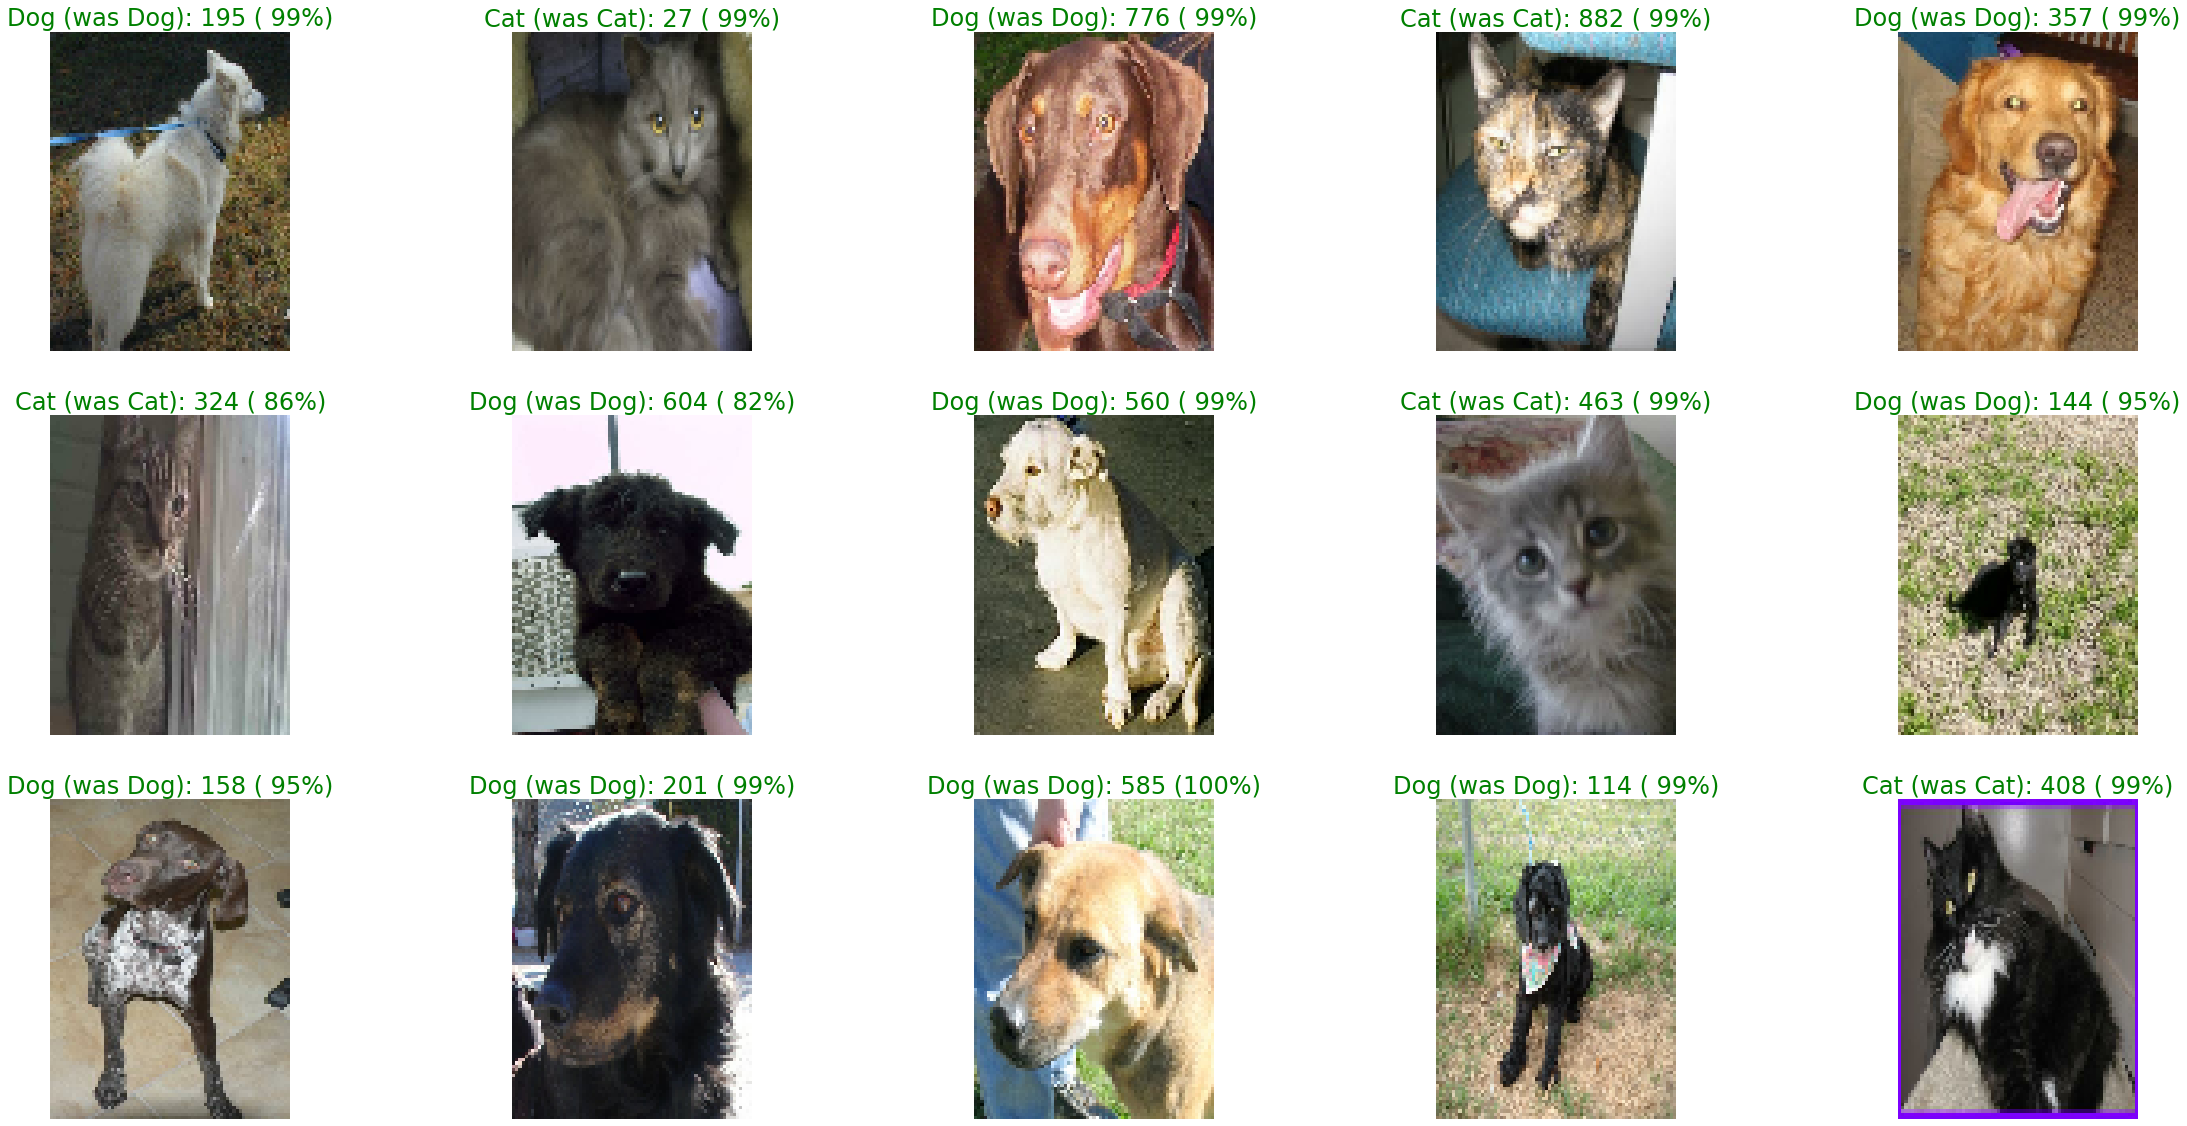

In [300]:
plot_gallery(model, val_image_batch.numpy()[rights], val_label_batch.numpy()[rights])

# Step VI: Saliency Maps - Are we using the right features?

In [301]:
X = val_image_batch
y = y_true

In [302]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from tensorflow.keras import backend as K

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


def plot_map(index, map_only=False):
    image = X[index]
    label = y[index]

    saliency_images = np.array([image], dtype='float32')
    
    def input_output_mapping(output):
        return (output[0][label])
    
    saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

    saliency_map = saliency(input_output_mapping, saliency_images)
    saliency_map = normalize(saliency_map)
    
    if map_only:
      plt.imshow(saliency_map[0], cmap='jet')
    else:
      plt.imshow(image);
      plt.imshow(saliency_map[0], cmap='jet', alpha=0.3);


(1.0, 0.5037584, 0.9310497)

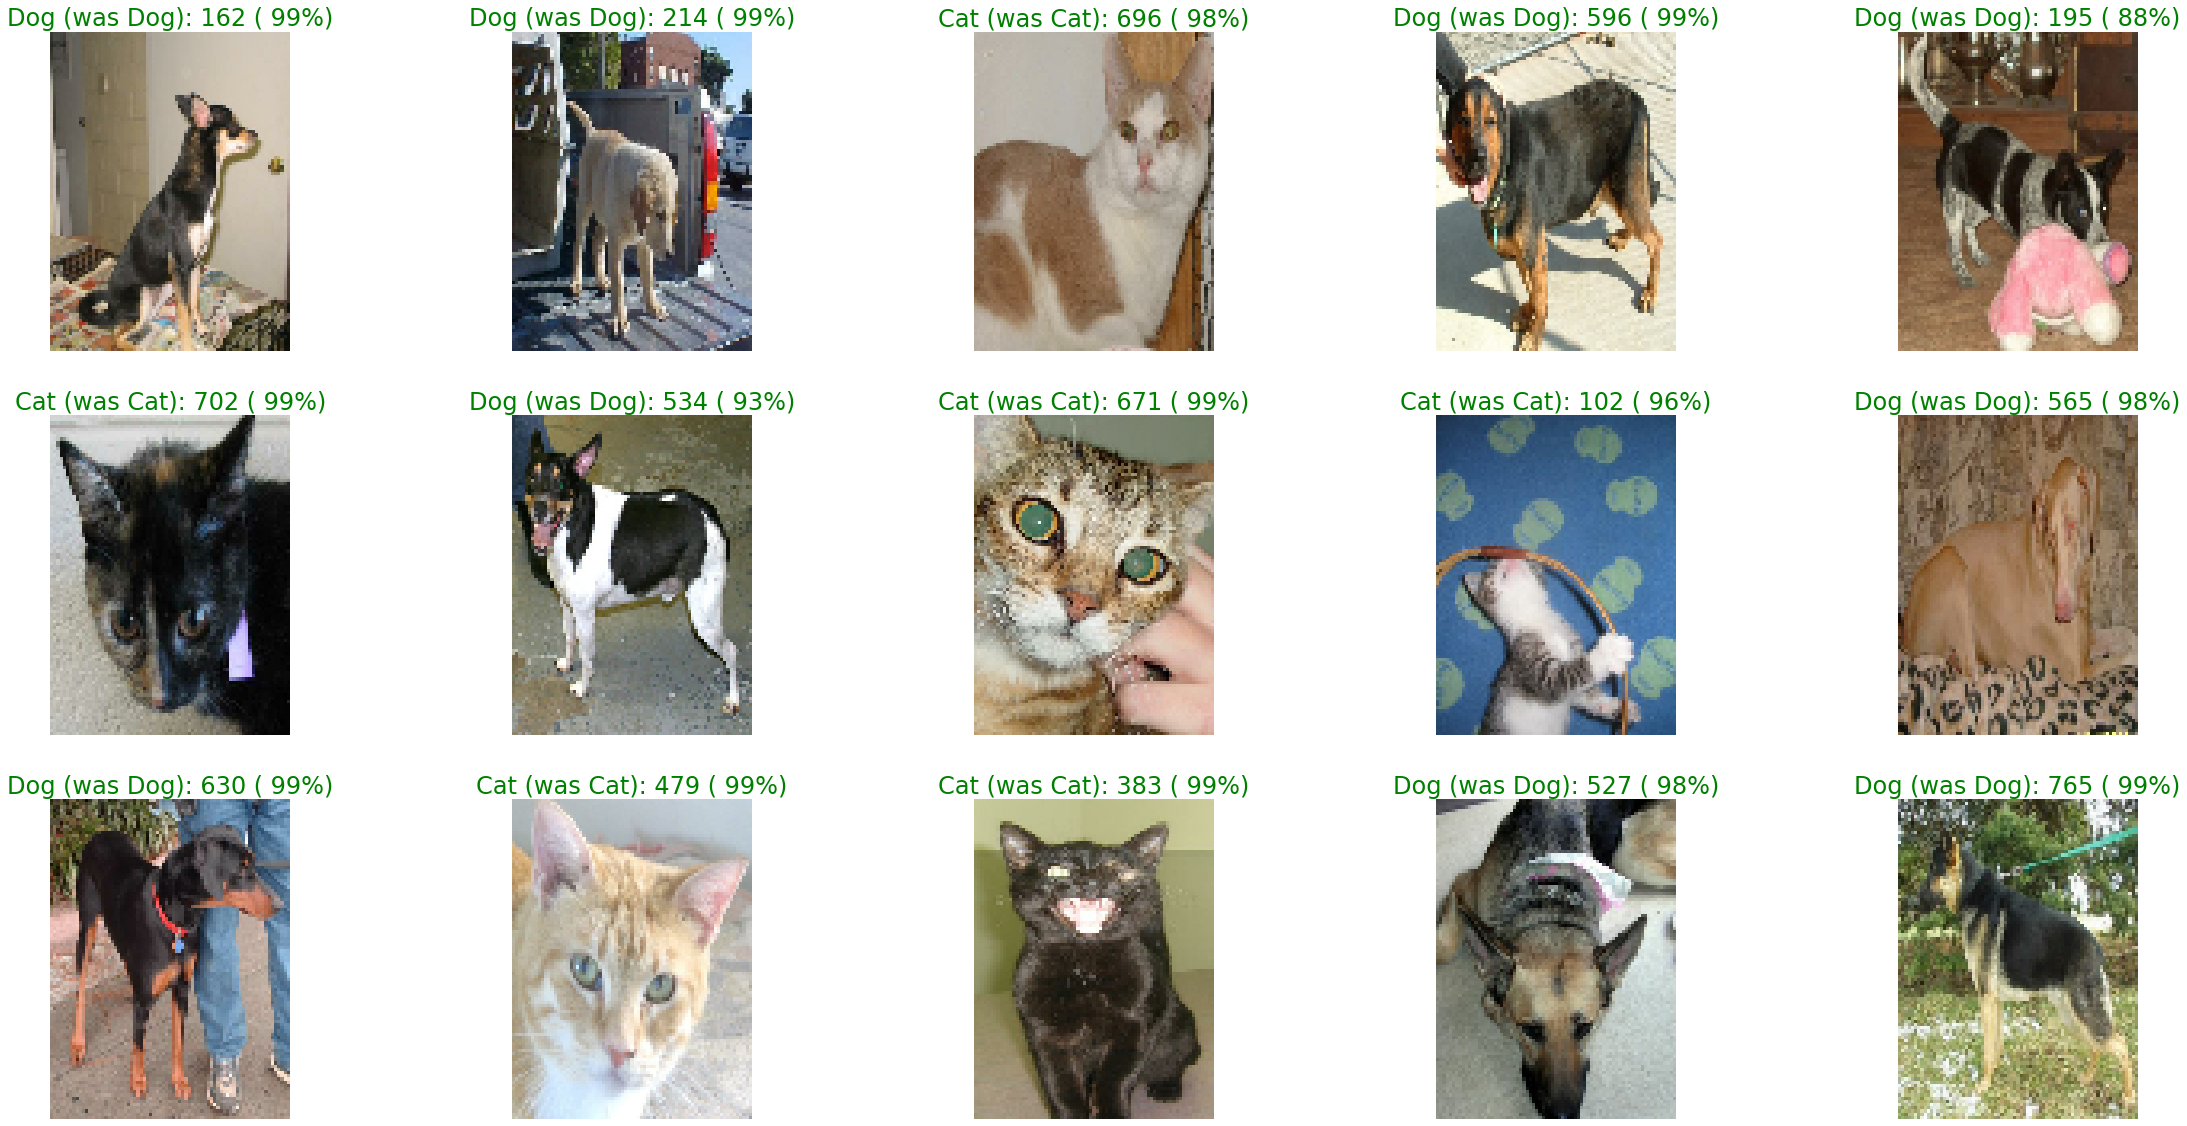

In [303]:
plot_gallery(model, val_image_batch, val_label_batch)

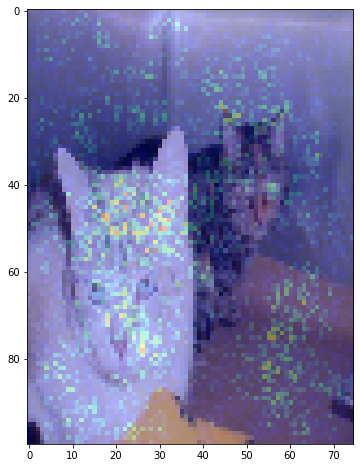

In [304]:
index = 406
index = 463

plot_map(index)
# plot_map(index, map_only=True)

## Exercise: Try saliency maps with more images

* Would you say the training is a success?
* What does the prediction concentrate on?
* Do you see differences between the groups we analyzed before?

# Step VII: Standard Architectures

* train with one of the standard architectures and contiunue with Step IV for evaluation 

In [ ]:
JUST_HERE_TO_STOP_EXECUTION

## Alternative: Standard CNN Architectures

<img src='https://cdn-images-1.medium.com/max/1600/1*kBpEOy4fzLiFxRLjpxAX6A.png'>

https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

## Keras Applications

Keras provides us with a lot of pre-defined network architectures for image classification (like ResNet and MobileNet)

https://keras.io/applications/

## Alternative: ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(classes=num_classes, weights=None, input_shape=input_shape)

model.summary()

In [ ]:
%%time

epochs = 20

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

In [ ]:
model.save('resnet50.h5')

## Alternative: MobileNet

* https://keras.io/applications/#mobilenet
* https://arxiv.org/pdf/1704.04861.pdf

_MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications https://arxiv.org/abs/1704.04861_
  * Spares Dense Layers at the end, thus vastly reducing parameters

_MobileNetV2: Inverted Residuals and Linear Bottlenecks https://arxiv.org/abs/1801.04381_

* reduces computational load from ResNet
* uses Depthwise Separable Convolutions, which is much more efficient, but can not perform as many different filters
* recommended to try first, often simply gets the job done

https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNet(classes=num_classes, weights=None, input_shape=input_shape)
# model = MobileNetV2(classes=num_classes, weights=None, input_shape=input_shape)

# Spares Dense Layers at the end, thus vastly reducing parameters
# If you wonder, final Logits layer has softmax activation: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
model.summary()

In [ ]:
%%time

epochs = 20

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

In [ ]:
model.save('mobilenet.h5')

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# model = MobileNet(classes=num_classes, weights=None, input_shape=input_shape)
model = MobileNetV2(classes=num_classes, weights=None, input_shape=input_shape)

# Spares Dense Layers at the end, thus vastly reducing parameters
# If you wonder, final Logits layer has softmax activation: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
model.summary()

In [ ]:
%%time

epochs = 20

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

In [ ]:
model.save('mobilenetv2.h5')

# Exercise: Choose a standard architecture (there are more) and try it against our custom model

* use the existing code above and simply replace the model
* use the code above for the new model
* regularization already is in place, if you need more tweak BATCH_SIZE, EPOCHS and use SGD

# Step VIII: Transfer Learning
* training using pre-traineed standard architectre and contiunue with Step IV for evaluation 

## Final Option: use the network pretrained on imagenet and retrain the classifier

<img src="https://djcordhose.github.io/ml-workshop/img/vgg-no-classifier.png">

* You can get the pre-defined network architectures pre-trained on a generic image data set (ImageNet)
* You can either use them as is
* Or retrain (fine tune weights) with your own images
* https://keras.io/applications/
* Might be helpful if you do not have a lot of data
* If a pre-trained network is helpful depends on whether your data looks similar to the data it has been pre-trained on

VGG16
* https://keras.io/applications/#vgg16
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb
* https://notebooks.azure.com/djcordhose/projects/tss-workshop/html/cnn-imagenet-retrain.ipynb

MobilNet V2 (our choice)
* https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
* https://www.tensorflow.org/tutorials/images/transfer_learning



## Replacing classifier

In [305]:
mobilnetv2_model = MobileNetV2(weights='imagenet')
len(mobilnetv2_model.layers)

156

In [306]:
mobilnetv2_model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
len(mobilnetv2_model_base.layers)

154

In [307]:
# mobilnetv2_model_base.summary()

In [308]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# try and vary between .4 and .75
drop_out = 0.50

inputs = mobilnetv2_model_base.output

# like mobilnet would do it
x = GlobalAveragePooling2D()(inputs)

# alternative, but with many more parameters
x = Flatten()(x)

# there is no final classifier in mobil net, we can have it, but we can also leave it out for now

# try a little classifier (or comment out one or both)
# x = Dense(256, activation='relu')(x)
# x = Dropout(drop_out)(x)

# x = Dense(256, activation='relu')(x)
# x = Dropout(drop_out)(x)

# softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

## Training classifier only

In [309]:
mobilnetv2_model_base.trainable = False

model = Model(inputs=mobilnetv2_model_base.input, outputs=predictions)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 38, 32)   864         input_21[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 38, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 38, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [310]:
%%time

epochs = 5
base_learning_rate = 0.001
# base_learning_rate = 0.0001

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             metrics=['accuracy'])

history = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    epochs=epochs,
    callbacks=[KerasLearningCurve()],
    verbose=0)

CPU times: user 2min 53s, sys: 18.3 s, total: 3min 11s
Wall time: 46.7 s


In [322]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [255]:
model.save('mobilenetv2-transfer.h5')

## Fine tuning top CNN layers

https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning

In [316]:
mobilnetv2_model_base.trainable = True

In [327]:
# tweak here
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilnetv2_model_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [319]:
%%time

initial_epochs = epochs

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate / 10.0),
             metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    normalized_train_ds, 
    validation_data=normalized_val_ds,
    callbacks=[KerasLearningCurve()],
    verbose=0,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
)

CPU times: user 6min 47s, sys: 48.5 s, total: 7min 35s
Wall time: 2min 11s


In [323]:
accuracy += history_fine.history['accuracy']
val_accuracy += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [324]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Categorical Crossentropy')

Text(0, 0.5, 'Categorical Crossentropy')

In [ ]:
model.save('mobilenetv2-transfer-fine-tuning.h5')